In [6]:
import pandas as pd
import numpy as np
import seaborn as sns

Dataset_Train = pd.read_csv('train.csv',nrows=1500000,dtype={"node1_id": np.int64, "node2_id":np.int64, "is_chat": np.int32})
Dataset_Test = pd.read_csv('test.csv',nrows=1550000, dtype={"id": np.int64, "node1_id": np.int64, "node2_id":np.int64})
Dataset_Features = pd.read_csv('user_features.csv',nrows=1550000)
Dataset_Features.rename(columns = {'node_id':'node1_id'},inplace=True)

Dataset_Features["node1_id"] = Dataset_Features["node1_id"].astype('int') 
Dataset_Features["f1"] = Dataset_Features["f1"].astype('int') 
Dataset_Features["f2"] = Dataset_Features["f2"].astype('int') 
Dataset_Features["f3"] = Dataset_Features["f3"].astype('int') 
Dataset_Features["f4"] = Dataset_Features["f4"].astype('int') 
Dataset_Features["f5"] = Dataset_Features["f5"].astype('int') 
Dataset_Features["f6"] = Dataset_Features["f6"].astype('int') 
Dataset_Features["f7"] = Dataset_Features["f7"].astype('int') 
Dataset_Features["f8"] = Dataset_Features["f8"].astype('int') 
Dataset_Features["f9"] = Dataset_Features["f9"].astype('int') 
Dataset_Features["f10"] = Dataset_Features["f10"].astype('int') 
Dataset_Features["f11"] = Dataset_Features["f11"].astype('int') 
Dataset_Features["f12"] = Dataset_Features["f12"].astype('int') 
Dataset_Features["f13"] = Dataset_Features["f13"].astype('int') 

Dataset_Merged = pd.merge(Dataset_Train,Dataset_Features,how='inner',on='node1_id')
Dataset_Merged_test = pd.merge(Dataset_Test,Dataset_Features,how='left',on='node1_id')
Dataset_Merged_test.fillna(0,inplace=True)
Dataset_Merged['is_chat'] = Dataset_Merged['is_chat'].astype('int')
Dataset_Merged["node2_id"] = Dataset_Merged["node2_id"].astype('int') 
Dataset_Merged['f14'] = pd.Categorical(Dataset_Merged['f13'], categories=range(15))

default_dummies = pd.get_dummies(Dataset_Merged["f14"],prefix='f14')
#default_dummies
default_dummies.drop(default_dummies.columns[0], axis=1, inplace=True)
Dataset_Merged = pd.concat([Dataset_Merged, default_dummies], axis=1)
Dataset_Merged.head()
#default_dummies


Dataset_Merged_test.drop(columns=['id'],inplace=True)
Dataset_Merged_test['f14'] = pd.Categorical(Dataset_Merged_test['f13'], categories=range(15))
default_dummies_test = pd.get_dummies(Dataset_Merged_test["f14"],prefix='f14',drop_first=True)

#default_dummies
default_dummies_test.drop(default_dummies_test.columns[0], axis=1, inplace=True)
Dataset_Merged_test = pd.concat([Dataset_Merged_test, default_dummies_test], axis=1)


metrics 0.7558707354877419


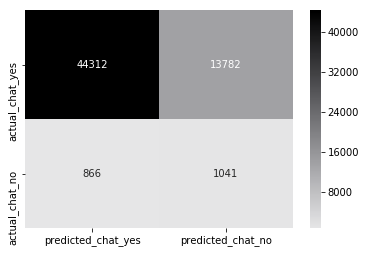

In [7]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt

from sklearn import metrics
from math import sqrt

x= Dataset_Merged[['node1_id','node2_id','f1','f2','f3','f4','f5','f6','f7','f8','f9','f10','f11','f12',
                  'f14_2','f14_3','f14_4','f14_5','f14_6','f14_7','f14_8','f14_9','f14_10','f14_11','f14_12','f14_13','f14_14']]
y= Dataset_Merged['is_chat']
x_train,x_test,y_train,y_test = train_test_split(x, y, test_size=0.2, random_state=42,stratify=y)

logreg = LogisticRegression(C=1.0, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='warn',
          n_jobs=None, penalty='l2', random_state=None, solver='liblinear',class_weight='balanced',
          tol=0.0001, verbose=0, warm_start=False)
x_proba = Dataset_Merged_test[['node1_id','node2_id','f1','f2','f3','f4','f5','f6','f7','f8','f9','f10','f11','f12',
                  'f14_2','f14_3','f14_4','f14_5','f14_6','f14_7','f14_8','f14_9','f14_10','f14_11','f14_12','f14_13','f14_14']]

logreg.fit(x_train,y_train)
y_pred = logreg.predict_proba(x_proba)


#now applying our learnt model on test and also ontrain data
y_log_pred_test = logreg.predict(x_test)
y_log_pred_train = logreg.predict(x_train)

#comparing the metrics of predicted lebel and real label of test data
print('metrics',metrics.accuracy_score(y_test, y_log_pred_test))
conf = metrics.confusion_matrix(y_test, y_log_pred_test)
y_log_proba = logreg.predict(x_proba)

cmap = sns.cubehelix_palette(50, hue=0.05, rot=0, light=0.9, dark=0, as_cmap=True)
sns.heatmap(conf,cmap = cmap,xticklabels=['predicted_chat_yes','predicted_chat_no'],yticklabels=['actual_chat_yes','actual_chat_no'],annot=True, fmt="d")
plt.show()

In [8]:
DataOut=list(zip( Dataset_Merged_test['node1_id'],  np.round(y_pred[:,1],2)))
df=pd.DataFrame(DataOut,columns=['id','is_chat'])
df[["id", "is_chat"]].to_csv("submit_results.csv", index=False)

In [9]:
from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score
from matplotlib import pyplot
metrics.roc_auc_score(y_test, y_log_pred_test, average='macro', sample_weight=None, max_fpr=None)

0.6543236916955142

AUC: 0.654


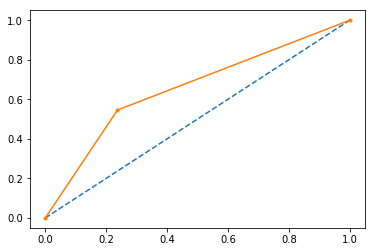

In [10]:
# calculate AUC
auc = roc_auc_score(y_test, y_log_pred_test)
print('AUC: %.3f' % auc)
# calculate roc curve
fpr, tpr, thresholds = roc_curve(y_test, y_log_pred_test)
# plot no skill
pyplot.plot([0, 1], [0, 1], linestyle='--')
# plot the roc curve for the model
pyplot.plot(fpr, tpr, marker='.')
# show the plot
pyplot.show()